# How to read and examine CETB files

This notebook shows:
* how to open, read, examine and display CETB file data
* how to access EASE-Grid 2.0 projection information and get the map coordinates of the upper left corner
* how to convert CETB dates from "days since epoch" to Gregorian dates
* how to use the cetbtools python package to do map transformations for lat/lon to/from row/col

As of this writing, (July 2017), we have delivered CETB data product for the AMSR-E, six SSM/Is and 4 SSMIS sensors, and are finishing delivery of the SMMR sensor data.  Find out what the latest publicly-available CETB data from NSIDC are at this location:

http://nsidc.org/data/nsidc-0630

For this notebook, I have included some v1.2 SSM/I F08 data to the data subdir.  If you wish to run this notebook on your local machine, you may have to adjust the paths and/or filenames.

## Import required packages for this notebook

Begin by setting up inline matplotlib display, and importing the netCDF4 reader package:

(Don't worry of you see a warning about font cache on your system, you can safely ignore it.)


In [1]:
%pylab notebook
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
import os
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

/Users/mj/miniconda3/envs/pmesdr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


## Open a CETB file and examine the TB data:

(You will likely have to change this to the location on your drive where you have downloaded some CETB data):

In [2]:
%cd ~/ExploringCETB/data
%ls *.nc

/Users/mj/ExploringCETB/data
NSIDC-0630-EASE2_N3.125km-F08_SSMI-1987305-37H-M-SIR-CSU-v1.2.nc
NSIDC-0630-EASE2_T3.125km-F08_SSMI-1987305-37H-A-SIR-CSU-v1.2.nc


The User Guide tab on the data page at NSIDC:

http://nsidc.org/data/nsidc-0630

has a section called "File Naming Convention" to help understand these filenames.

Choose a file to open, and display the file-level global attributes.  These include information like the product version number, the source swath files used to derive this CETB file, the date the CETB grid was produced, and discovery metadata like spatial and temporal coverages:

In [3]:
filename = "NSIDC-0630-EASE2_T3.125km-F08_SSMI-1987305-37H-A-SIR-CSU-v1.2.nc"
f = Dataset(filename, "r", format="NETCDF4")
f

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6, ACDD-1.3
    title: MEaSUREs Calibrated Passive Microwave Daily EASE-Grid 2.0 Brightness Temperature ESDR
    product_version: v1.2
    software_version_id: 0.2.33
    software_repository: git@bitbucket.org:nsidc/measures-byu.git
    history: meas_meta_sir
    comment: Epoch date for data in this file: 1987-11-01 00:00:00Z
    source: CSU SSM/I FCDR V01R00
    references: Long, D. G. and M. J. Brodzik. 2016. Optimum Image Formation for Spaceborne Microwave Radiometer Products. IEEE Trans. Geosci. Remote Sensing, 54(5):2763-2779, doi:10.1109/TGRS.2015.2505677.
Algorithm Theoretical Basis Document:  https://nsidc.org/sites/nsidc.org/files/technical-references/MEaSUREs_CETB_ATBD.pdf

    metadata_link: http://nsidc.org/data/nsidc-0630.html
    summary: An improved, enhanced-resolution, gridded passive microwave Earth System Data Record for monitoring cryospheric and hydrologic tim

NetCDF files contain metadata and several kinds of variables.  "Dimension" variables are special, in that the name of the variable and the size of the variable are called the same thing.  For example, in the last couple lines of output here you will see "time(time)" and "y(y)" and "x(x)".  These are the dimension variables for the CETB data.

Note that this file contains:
* two file attributes called "geospatial_x_resolution" and "geospatial_y_resolution", which store the grid resolution in meters
* 3 dimension variables (time, y and x) and 
* 1 variable with only metadata called crs() and
* 5 data (TB, TB_num_samples, Incidence_angle, TB_std_dev and TB_time)

## Get the projection information

The crs variable contains "coordinate reference system" information about the projection used for this file.  The geospatial_x_resolution and geospatial_y_resolution tell you about the grid resolution of the data.

To read the crs variable, use:


In [4]:
crs = f.variables['crs']
crs

<type 'netCDF4._netCDF4.Variable'>
|S1 crs()
    grid_mapping_name: lambert_cylindrical_equal_area
    longitude_of_central_meridian: 0.0
    standard_parallel: 30.0
    false_easting: 0.0
    false_northing: 0.0
    semi_major_axis: 6378137.0
    inverse_flattening: 298.257223563
    proj4text: +proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m
    srid: urn:ogc:def:crs:EPSG::6933
    coverage_content_type: auxiliaryInformation
    references: ["EASE-Grid 2.0 documentation: http://nsidc.org/data/ease/ease_grid2.html", "Brodzik, Mary J.; Billingsley, Brendan; Haran, Terry; Raup, Bruce; Savoie, Matthew H. 2012.", "EASE-Grid 2.0: Incremental but Significant Improvements for Earth-Gridded Data Sets.", "ISPRS Int. J. Geo-Inf. 1, no. 1: 32-45.", "Brodzik, Mary J.; Billingsley, Brendan; Haran, Terry; Raup, Bruce; Savoie, Matthew H. 2014.", "Correction: Brodzik, M. J., et al. EASE-Grid 2.0: Incremental but Significant Improvements for Earth-Gridded Data Se

We have encoded the projection information in several ways in this file, including:

* CF-compliant projection attributes, including grid_mapping_name, longitude_of_central_meridian, standard_parallel, false_easting, false_northing, semi_major_axis and inverse_flattening
* proj4txt: the proj4 string for this projection
* srid: the EPSG code for this projection
* crs_wkt: the "well-known text" string that describes the projection
* long_name: the NSIDC mapx grid paramater definition name
 

## Get the map coordinates of the UL corner

If you are looking for the map coordinates (in meters) of the upper left corner of the grid, you can obtain them from the valid_range attributes of the x and y dimension variables, like this:


In [5]:
print f.variables['y'], f.variables['x']

<type 'netCDF4._netCDF4.Variable'>
float64 y(y)
    standard_name: projection_y_coordinate
    coverage_content_type: coordinate
    long_name: y
    units: meters
    axis: Y
    valid_range: [-6756820.2  6756820.2]
unlimited dimensions: 
current shape = (4320,)
filling on, default _FillValue of 9.96920996839e+36 used
 <type 'netCDF4._netCDF4.Variable'>
float64 x(x)
    standard_name: projection_x_coordinate
    coverage_content_type: coordinate
    long_name: x
    units: meters
    axis: X
    valid_range: [-17367530.44  17367530.44]
unlimited dimensions: 
current shape = (11104,)
filling on, default _FillValue of 9.96920996839e+36 used



The left edge of the x dimension is (in meters) -17367530.44. and the top edge of the y dimension is 6756820.2, so the projected map coordinates of the upper left corner of the upper left cell is [x, y] = [-17367530.44 m, 6756820.2 m]

## Read and display a TB array

The dimension variables x and y indicate that this data is a square array that is 4320 rows by 11104 cols.  To read the 4320x11104 TB array into memory, use:

In [6]:
data = f.variables['TB'][:]
print np.shape(data), np.amin(data), np.amax(data)

(1, 4320, 11104) 98.97 305.94


We have stored each data array with a single time dimension for the date in order to facilitate netCDF tools that allow data across many files to be concatenated by date.  To work just with the 2D array of data, you can use the numpy "squeeze" function like this (notice that the degenerate first dimension for time has now been removed and you are left with a 2D array):

In [7]:
data = np.squeeze(data)
print np.shape(data)

(4320, 11104)


## Get the date of the data in this file

You can get the date of the data in this file several ways.  The easiest, human-readable form is in the file attribute "comment".  At this point the comment attribute only has the date in it, but over time the comment variable might get more difficult to parse, since tools like NetCDF Command-Line Operators often append to this string when called on a given file.  For now, the comment contains just the epoch date string:

In [8]:
f.comment

u'Epoch date for data in this file: 1987-11-01 00:00:00Z'

A more machine-readable way to access the date is in the time coordinate variable contents:

In [9]:
d = f.variables['time']
date = d[:]
print d
print date


<type 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    coverage_content_type: coordinate
    long_name: ANSI date
    units: days since 1972-01-01 00:00:00
    calendar: gregorian
    axis: T
    valid_range: [  0.00000000e+000   1.79769313e+308]
unlimited dimensions: time
current shape = (1,)
filling on, default _FillValue of 9.96920996839e+36 used

[ 5783.]


Note that this date is encoded as "days since 1972-01-01".  To convert the stored number in the time array to a Gregorian date, use the num2date function imported from the netCDF4 package, and use the strftime function to format it as a string however you specify with the formatting string you input to strftime:

In [10]:
greg_date = num2date(date[:],units=d.units,calendar=d.calendar)
print(greg_date)
print greg_date[0].strftime("%Y-%m-%d")
print greg_date[0].strftime("%b %d %Y")

[datetime.datetime(1987, 11, 1, 0, 0)]
1987-11-01
Nov 01 1987


## Display the TB array

Next, to display the brightness temperatures in this data array as an image, use imshow:

<IPython.core.display.Javascript object>


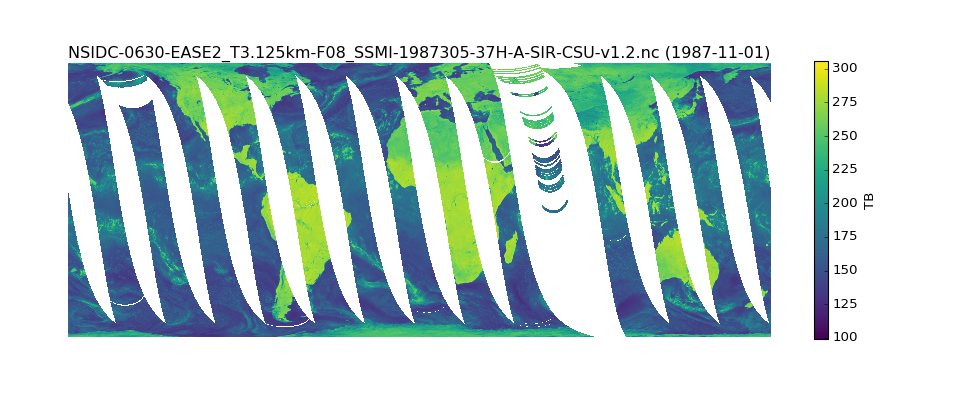

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.set_title("%s (%s)" % 
             (os.path.basename(filename), greg_date[0].strftime("%Y-%m-%d")))
plt.imshow(data, cmap='viridis', vmin=np.amin(data), vmax=np.amax(data), interpolation='nearest')
plt.axis('off')
plt.colorbar(shrink=0.75,label='TB')
plt.tight_layout()

## Display the number of measurement samples used for each cell in the image reconstruction

Similarly, the number of samples used to derive each grid cell in the image reconstruction is in the variable TB_num_samples, which can be read and displayed like this:

In [12]:
num = np.squeeze(f.variables['TB_num_samples'][:])

<IPython.core.display.Javascript object>


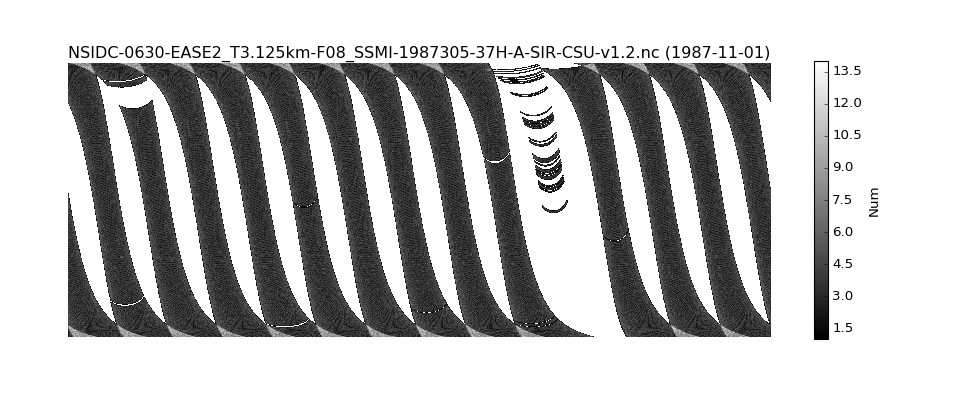

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.set_title("%s (%s)" % 
             (os.path.basename(filename), greg_date[0].strftime("%Y-%m-%d")))
plt.imshow(num, cmap=plt.cm.gray, vmin=np.amin(num), vmax=np.amax(num), interpolation='nearest')
plt.axis('off')
plt.colorbar(shrink=0.75, label='Num')
plt.tight_layout()

## Doing (row,col) <--> (lat, lon) map transformations

The python package cetbtools contains transformation routines for lat,lon <--> x,y <--> row,col coordinates of locations in the EASE-Grid 2.0 CETB grids.  

cetbtools is distributed via the anaconda.org package distribution system.  You can install the package on your machine using this command in your local conda env:

conda install -c https://conda.anaconda.org/nsidc cetbtools

This package is currently available for python on mac OS X and linux platforms.

Assuming you have cetbtools installed, you should be able to import it into the notebook:

In [14]:
from cetbtools.ease2conv import Ease2Transform

You can access the help and information about the Ease2Transform class:

In [15]:
help(Ease2Transform)

Help on class Ease2Transform in module cetbtools.ease2conv:

class Ease2Transform
 |  The Ease2Transform class provides map projection conversion routines
 |  for geographic (lat/lon), grid (row/col), and map (x,y) locations in
 |  EASE-Grid 2.0 projections.
 |  
 |  2016-02-27 M. J. Brodzik brodzik@nsidc.org 303-492-8263
 |  National Snow & Ice Data Center, Boulder CO
 |  Copyright (C) 2016 Regents of the University of Colorado at Boulder
 |  
 |  Methods defined here:
 |  
 |  __init__(self, gridname=None, verbose=False)
 |      cetbtools.ease2conv.EASE2Transform(gridname)
 |      
 |      Returns a Transform object for the specified gridname.
 |      
 |      Parameters: gridname : string
 |                      EASE-Grid 2.0 gridname, following the pattern:
 |                      "EASE2-<proj><res>km", where:
 |                      <proj> is "N", "S" or "T"
 |                      <res> is "25", "12.5", "6.25" or "3.125"
 |                  verbose: bool, optional
 |             

Getting back to the file we have just opened, in order to get the row, col coordinates of a pixel at a specific location, we can initialize an Ease2Transform object with the long_name of the grid in this file.  The initializer for this class need only be called once, and then the "geographic_to_grid" or "grid_to_geographic" methods can be called repeatedly.  The initializer takes one input argument, the NSIDC mapx name for the projection and grid that is stored in the crs.long_name attribute we examined earlier:

In [16]:
print crs.long_name

EASE2_T3.125km


In [17]:
grid = Ease2Transform(crs.long_name)

The Ease2Transform method "geographic_to_grid" can be used to transform a (lat, lon) coordinate to (row, col).  The returned values for row, col will be real-valued, and need to be rounded (up at 0.5) to get the integer values of row, col that can be used to index into the data arrays:

In [18]:
lat = 40. # latitude in decimal degrees
lon = -95.  # longitude in decimal degress
(row, col) = grid.geographic_to_grid(lat, lon)
print row, col
(irow, icol) = (int(round(row)), int(round(col)))
print irow, icol

654.753461075 2621.27777691
655 2621


In [19]:
print "TB at (40.0N, 95.0W) is: %f K" % data[irow, icol]
print "Num samples used: %d" % num[irow, icol]

TB at (40.0N, 95.0W) is: 256.059998 K
Num samples used: 4


Use grid_to_geographic to transform a (row, col) coordinate to (lat, lon):

In [20]:
print grid.grid_to_geographic(row,col)

(39.99999999316158, -95.0)


Lastly, remember to close the netCDF file:

In [21]:
f.close()

Combining many of the previous steps, I can also read a Northern Hemisphere file, like this:

In [23]:
filename = "NSIDC-0630-EASE2_N3.125km-F08_SSMI-1987305-37H-M-SIR-CSU-v1.2.nc"
f = Dataset(filename, "r", format="NETCDF4")
data = f.variables['TB'][:]
data = np.squeeze(data)
num = f.variables['TB_num_samples'][:]
num = np.squeeze(num)

<IPython.core.display.Javascript object>


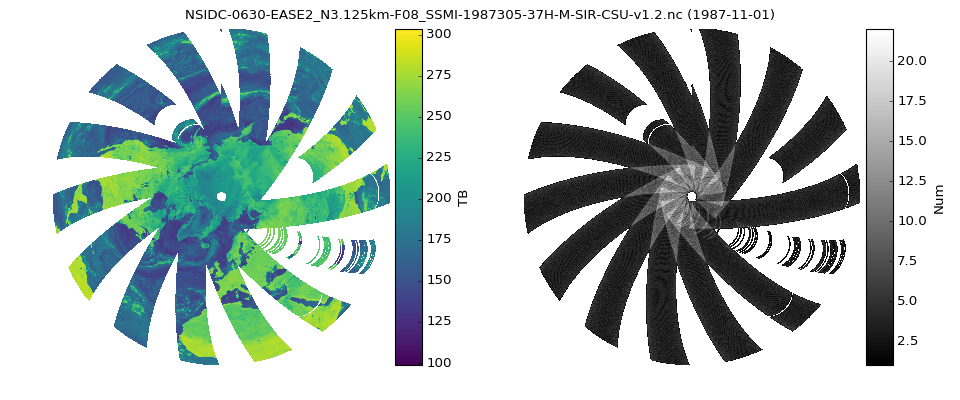

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,2, figsize=(12,5))
fig.suptitle("%s (%s)" % (
        os.path.basename(filename), greg_date[0].strftime("%Y-%m-%d")))
ax[0].axis('off')
dataAx = ax[0].imshow(data, cmap='viridis', vmin=np.amin(data), 
                      vmax=np.amax(data), interpolation='nearest',
                      aspect='equal')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="8%", pad=0.08)
dataCbar = plt.colorbar(dataAx, cax=cax0, label='TB')
ax[0].axis('off')

numAx = ax[1].imshow(num, cmap=plt.cm.gray, vmin=np.amin(num), 
                     vmax=np.amax(num), interpolation='nearest',
                     aspect='equal')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="8%", pad=0.08)
numCbar = plt.colorbar(numAx, cax=cax1, label='Num')
ax[1].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


In [ ]:
f.close()

Feel free to contact me with questions about the data or this tutorial: brodzik_at_nsidc.org.